# Customer Segmentation Analysis
### RFM Analysis for customer segmentation using k-means clustering

There are lots of ways to classify customers and divide them by groups. Segmentation based on RFM (Recency, Frequency, and Monetary) has been in use for over 50 years especially by retail industry. This study focuses in try a different method for customer segmentation and compare the results between a classic RFM segmentation and a famous unsupervised learning algorithm called k-means. 

#### Data Set Information:

The dataset we are going to use is composed of 8 features and 541.909 instances of transaction history data occurring from Jan 2010 to Sep 2011 for a UK-based online retail. The company mainly sells unique all-occasion gifts and many customers of the company are wholesalers. 

**Source**: [UCI Online Retail Data Set](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

#### Steps

- Transform data to fit RFM model and then segment based on RFM principle.
- Clustering using k-Means algorithm
- Compare the results between RFM principle and unsupervised k-means clustering. 

# 0. Import libraries

In [51]:
# import libraries
import pandas as pd
import numpy as np
import datetime 

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)

# 1. Import dataset

In [2]:
# Import the dataset
retail = pd.read_excel('Online Retail.xlsx')

In [3]:
# Drop rows missing customerID since this feature is key for analysis
retail.dropna(subset=['CustomerID'], inplace=True)

# 2. Define subset

In [4]:
# I'm taking 30% of samples since the dataset is quite big to process locally
retail.sample(frac=0.3, random_state=42, replace=True)
retail.reset_index(drop=True, inplace=True)

# 3. Explore  and clean the data

In [5]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
retail.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [7]:
# Check for negative values
indexNegatives = retail[ retail['UnitPrice'] < 0].index
 
# Delete these row indexes from dataFrame
retail.drop(indexNegatives, inplace=True)

In [8]:
min(retail.UnitPrice)

0.0

In [9]:
retail = retail.astype({'UnitPrice': 'float32', 'CustomerID': 'int64'})

The 8 feature in the dataset:
- **InvoiceNo**: Invoice number. Nominal, A unique 6-digit int number assigned to each transaction. The invoice numbers that starts with C (e.g. C581568) are cancellation.
- **StockCode**: SKU. Nominal, a 5-digit integral number to each distinct product.
- **Description**: Item name. Nominal.
- **Quantity**: The quantities of each item per transaction. Numeric.
- **InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice**: Item price. Numeric, price per unit.
- **CustomerID**: Customer Id. Nominal, a unique 5-digit int number assigned to each customer.
- **Country**: Country name. Nominal, the name of the country where each customer resides.

# 4. RFM values
Since **frequency** is the number of transaction in the last 12 months and **monetary value** is the total amout of money the customers spent in the last 12 months, we need to setup the time frame of our "snapshot".

In [10]:
# I'm transforming datetime to YYYY-MM-DD to facilitate aggregations.
retail['InvoiceDay'] = retail.InvoiceDate.apply(lambda x: datetime.datetime(x.year, x.month, x.day))
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01


In [11]:
print('Min : {}, Max : {}'.format(min(retail.InvoiceDay), max(retail.InvoiceDay)))

Min : 2010-12-01 00:00:00, Max : 2011-12-09 00:00:00


In [12]:
snapshot_date = max(retail.InvoiceDay) + datetime.timedelta(1)

## 4.1. Create total spend value

In [13]:
retail['TotalSpend'] = round(retail.Quantity * retail.UnitPrice, 2)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalSpend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34


## 4.2. Create RFM values

In [14]:
# calculate RFM values
df_rfm = retail.groupby('CustomerID').agg({
                        'InvoiceDate' : lambda x: (snapshot_date - x.max()).days,
                        'InvoiceNo' : 'count', 
                        'TotalSpend' : 'sum'})

In [15]:
df_rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']

In [16]:
df_rfm.columns

Index(['Recency', 'Frequency', 'MonetaryValue'], dtype='object')

## 4.3. Define RFM quartiles

In [17]:
recency_labels = range(5, 0, -1)
recency_groups = pd.qcut(df_rfm.Recency, q=5, labels=recency_labels)

frequency_labels = range(1, 6)
frequency_groups = pd.qcut(df_rfm.Frequency, q=5, labels=frequency_labels)

mv_labels = range(1, 6)
mv_groups = pd.qcut(df_rfm.MonetaryValue, q=5, labels=mv_labels)

mv_groups.head()

CustomerID
12346    1
12347    5
12348    4
12349    4
12350    2
Name: MonetaryValue, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [18]:
# Make a new columns for labels
df_rfm['R'] = recency_groups.values
df_rfm['F'] = frequency_groups.values
df_rfm['M'] = mv_groups.values

In [19]:
# Calculate RFM score
df_rfm['RFM_Segment'] = df_rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
df_rfm['RFM_Score'] = df_rfm[['R', 'F', 'M']].sum(axis = 1)
df_rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,325,2,0.00,1,1,1,111,3.0
12347,2,182,4310.00,5,5,5,555,15.0
12348,75,31,1797.24,2,3,4,234,9.0
12349,18,73,1757.55,4,4,4,444,12.0
12350,310,17,334.40,1,2,2,122,5.0


In [20]:
df_rfm['RFM_Score'] = df_rfm['RFM_Score'].astype(int)

## 4.4. Split customers in groups

In [21]:
# assign labels from total score
score_labels = ['Bronze', 'Silver', 'Gold', 'Diamond']
score_groups = pd.qcut(df_rfm.RFM_Score, q=4, labels=score_labels)
df_rfm['RFM_Group'] = score_groups.values

df_rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Group
CustomerID,,,,,,,,,
12346,325,2,0.00,1,1,1,111,3,Bronze
12347,2,182,4310.00,5,5,5,555,15,Diamond
12348,75,31,1797.24,2,3,4,234,9,Silver
12349,18,73,1757.55,4,4,4,444,12,Gold
12350,310,17,334.40,1,2,2,122,5,Bronze


In [91]:
df_rfm_agg = df_rfm.groupby('RFM_Group').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean', 'count']
    })

df_rfm_agg.head(20)

Recency   Frequency MonetaryValue      
                 mean        mean          mean count
RFM_Group                                            
Bronze     190.993039   14.290797    245.298036  1293
Silver      85.778976   36.997305    656.721707  1113
Gold        44.461840   86.027397   1387.670822  1022
Diamond     13.310381  274.632415   6193.903337   944

In [90]:
fig = px.scatter_3d(df_rfm, x='Recency', y='Frequency', z='MonetaryValue',
              color='RFM_Group', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# 5. Customer Segmentation with K-means

## 5.1. Preprocessing

As k-means clustering require data to be normalized, the first step is to preprocess data.

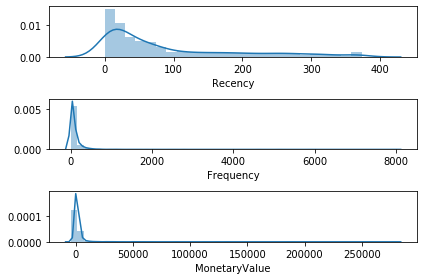

In [23]:
# Plot the distribution of RFM values
plt.subplot(3, 1, 1)
sns.distplot(df_rfm.Recency)

plt.subplot(3, 1, 2)
sns.distplot(df_rfm.Frequency)

plt.subplot(3, 1, 3)
sns.distplot(df_rfm.MonetaryValue)

plt.tight_layout()
plt.show()

As you can see above, the values are skewed and need to be normalized but due to the zero or negative values in Recency and MonetaryValue, is needed to set them anything above zero before transformation and scaling.

In [24]:
max(df_rfm.MonetaryValue)

279489.0199999999

In [25]:
def remove_negatives(number):
    if number <= 0:
        return int(1)
    else:
        return float(number)

# apply the function to Recency and MonetaryValue column 
df_rfm['Recency'] = [remove_negatives(x) for x in df_rfm.Recency]
df_rfm['MonetaryValue'] = [remove_negatives(x) for x in df_rfm.MonetaryValue]

# unskew the data
df_rfm_log = df_rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis= 1)
df_rfm_log.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,5.783825,0.693147,0.000000
12347,0.693147,5.204007,8.368693
12348,4.317488,3.433987,7.494007
12349,2.890372,4.290459,7.471676
12350,5.736572,2.833213,5.812338


In [26]:
df_rfm_log = df_rfm_log[['Recency', 'Frequency', 'MonetaryValue']].round(3)
df_rfm_log.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,5.784,0.693,0.000
12347,0.693,5.204,8.369
12348,4.317,3.434,7.494
12349,2.890,4.290,7.472
12350,5.737,2.833,5.812


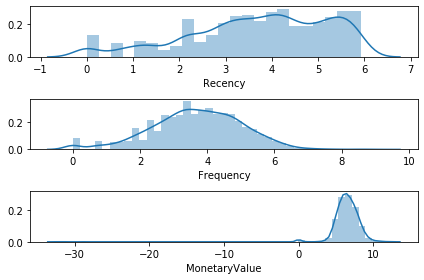

In [27]:
# Plot the distribution of RFM values
plt.subplot(3, 1, 1); sns.distplot(df_rfm_log.Recency)
plt.subplot(3, 1, 2); sns.distplot(df_rfm_log.Frequency)
plt.subplot(3, 1, 3); sns.distplot(df_rfm_log.MonetaryValue)

plt.tight_layout()
plt.show()

In [28]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_rfm_log)


# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index =df_rfm.index, columns=df_rfm_log.columns)
rfm_scaled.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,1.381413,-2.230378,-3.539752
12347,-1.993513,1.133425,1.046945
12348,0.408909,-0.186444,0.567394
12349,-0.537078,0.451865,0.555337
12350,1.350256,-0.634604,-0.354439


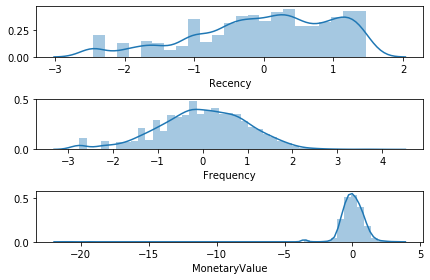

In [29]:
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.MonetaryValue, label = 'MonetaryValue')

plt.tight_layout()
plt.show()

## 5.2. K-means clustering

#### With the Elbow method, we can get the optimal number of clusters.



In [30]:
# initiate an empty dictionary
elbow = {}

# Elbow method with for loop
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter=300)
    kmeans.fit(rfm_scaled)
    elbow[i] = kmeans.inertia_

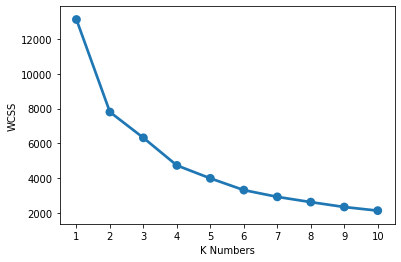

In [31]:
sns.pointplot(x = list(elbow.keys()), y = list(elbow.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [32]:
# Choose n_clusters = 3
cluster = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300)
cluster.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [33]:
# Assign the clusters to RFM dataframe
df_rfm['K_Cluster'] = cluster.labels_
df_rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,RFM_Group,K_Cluster
CustomerID,,,,,,,,,,
12346,325.0,2,1.00,1,1,1,111,3,Bronze,1
12347,2.0,182,4310.00,5,5,5,555,15,Diamond,0
12348,75.0,31,1797.24,2,3,4,234,9,Silver,2
12349,18.0,73,1757.55,4,4,4,444,12,Gold,0
12350,310.0,17,334.40,1,2,2,122,5,Bronze,1


In [50]:
fig = px.scatter_3d(rfm_scaled, x='Recency', y='Frequency', z='MonetaryValue',
              color='K_Cluster', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# 6. Visualization

The common plot in marketing for RFM visualization is the snail plot and heatmap.
I'll use the scaled dataframe (the one that was used to compute kmeans clusters) with normalized rfm values to plot the graphs. 

## Snake plot

In [34]:
rfm_scaled['K_Cluster'] = cluster.labels_
rfm_scaled['RFM_Group'] = df_rfm.RFM_Group
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,CustomerID,Recency,Frequency,MonetaryValue,K_Cluster,RFM_Group
0,12346,1.381413,-2.230378,-3.539752,1,Bronze
1,12347,-1.993513,1.133425,1.046945,0,Diamond
2,12348,0.408909,-0.186444,0.567394,2,Silver
3,12349,-0.537078,0.451865,0.555337,0,Gold
4,12350,1.350256,-0.634604,-0.354439,1,Bronze


In [35]:
# unpivoting the dataframe
rfm_scaled_melted = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'RFM_Group', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_scaled_melted.head()

,CustomerID,RFM_Group,K_Cluster,Metrics,Value
0,12346,Bronze,1,Recency,1.381413
1,12347,Diamond,0,Recency,-1.993513
2,12348,Silver,2,Recency,0.408909
3,12349,Gold,0,Recency,-0.537078
4,12350,Bronze,1,Recency,1.350256


In [36]:
rfm_scaled_melted['Metrics'].unique()

array(['Recency', 'Frequency', 'MonetaryValue'], dtype=object)

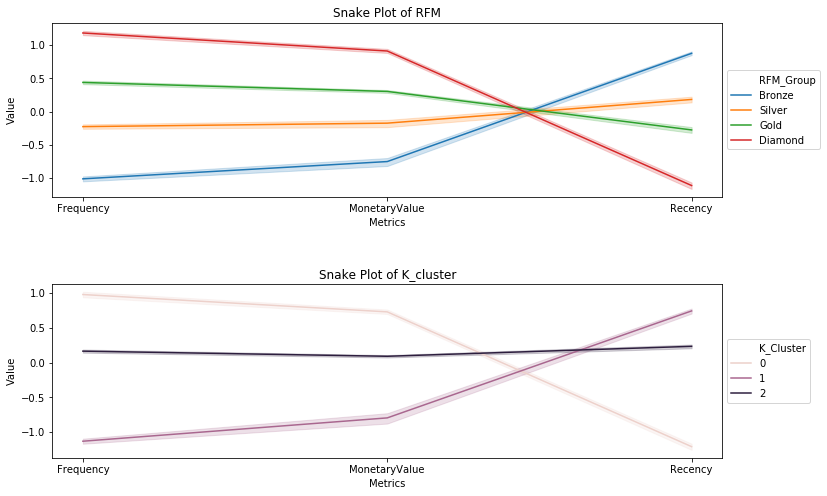

In [37]:
# Snake plot with RFM Model
f, axes = plt.subplots(2, figsize=(12, 8))
f.subplots_adjust(hspace=0.5)
sns.lineplot(x='Metrics', y ='Value', hue='RFM_Group', data=rfm_scaled_melted, ax=axes[0])
axes[0].set_title('Snake Plot of RFM')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Snake plot with K-Means
sns.lineplot(x= 'Metrics', y = 'Value', hue ='K_Cluster', data = rfm_scaled_melted, ax=axes[1])
axes[1].set_title('Snake Plot of K_cluster')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## 3d scatter plot

In [87]:
# Initialize figure with 4 3D subplots
f = make_subplots(
    rows=1, cols=2,
    specs=[[{'is_3d': True}, {'is_3d': True}]],
    subplot_titles=("K-Means", "RFM Model"))

# Generate data
myColors = ['#db437b', '#d3d64d', '#568ce2', '#b467bc']
for i in range(3):
    df = rfm_scaled[rfm_scaled.K_Cluster == i]
    x = df.Recency
    y = df.Frequency
    z = df.MonetaryValue
    color = myColors[i]
    
    f.add_trace(go.Scatter3d(x=x, y=y, z = z, name =str(i),
                         mode = 'markers', marker= dict(size=5, color=color, opacity = .7), scene='scene1'))

group = rfm_scaled.RFM_Group.tolist()

for i in range(4):
    df = rfm_scaled[rfm_scaled.RFM_Group == group[i]]
    x = df.Recency
    y = df.Frequency
    z = df.MonetaryValue
    color = myColors[i]
    
    f.add_trace(go.Scatter3d(x = x, y = y, z = z, name = group[i], 
                         mode = 'markers', marker = dict(size = 5, color = color, opacity = .7), scene='scene2'))
    
f.update_layout(
    title_text='K-Means clusters and RFM Model segmentations',
    height=700,
    width=1000,
    showlegend=False,
    autosize=True
)

fig = go.FigureWidget(f)

def cam_change(layout, camera):
    fig.layout.scene2.camera = camera

fig.layout.scene1.on_change(cam_change, 'camera')
fig.show()